In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import shap
from shap import Explanation
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Load data

In [2]:
# Load data
df = pd.read_csv('../data/clean_data.csv')

# Convert to datetime to avoid errors
df['activity_month'] = pd.to_datetime(df['activity_month'])
df['ftd_date'] = pd.to_datetime(df['ftd_date'])
df['qp_date'] = pd.to_datetime(df['qp_date'])

df.head()

,activity_month,account_id,brand_id,reg_date,ftd_date,qp_date,ben_login_id,tracker_id,player_reg_product,total_deposit,total_handle,total_ngr,months_active
0,2023-11-01,154497623,AZ,2022-10-28,2022-10-28,2022-10-28,actionnetwork,7039239,BETTING,0.0,5.0,4.00,13
1,2023-11-01,184718245,OH,2023-11-13,2023-11-13,2023-11-13,actionnetwork,7106987,BETTING,10.0,210.0,138.98,0
2,2023-11-01,183573211,OH,2023-11-06,2023-11-06,2023-11-06,BCUSA22NP,7106983,BETTING,10.0,210.0,-320.22,0
3,2023-11-01,153923970,PA,2022-09-12,2022-09-12,2022-09-12,BCUSA22N,7086406,CASINO,0.0,0.0,0.00,14
4,2023-11-01,174413334,TN,2023-10-05,2023-10-05,2023-11-21,BCUSA22N,7086400,BETTING,60.0,303.0,68.46,1


### 2. Feature engineering

In [3]:
# Sort by account_id and activity_month
df = df.sort_values(['account_id', 'activity_month'])

# Define the target variable (Churn)
df['next_month'] = df.groupby('account_id')['activity_month'].shift(-1) # Identify if user was active in the next month
df['churned'] = (df['next_month'].isna()) | ((df['next_month'] - df['activity_month']) > pd.Timedelta(days=32)) # Identify if user churned
df = df.dropna(subset=['next_month']) # Remove the last month for each player (can't determine if they churned)

# Label encode categorical features identified in EDA
for col in ['brand_id', 'ben_login_id', 'player_reg_product']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Target encode tracker_id 
mean_churn_by_tracker = df.groupby('tracker_id')['churned'].mean()
df['tracker_id_encoded'] = df['tracker_id'].map(mean_churn_by_tracker)

df.head()

,activity_month,account_id,brand_id,reg_date,ftd_date,qp_date,ben_login_id,tracker_id,player_reg_product,total_deposit,total_handle,total_ngr,months_active,next_month,churned,tracker_id_encoded
17569,2022-12-01,150745090,8,2022-03-05,2022-04-08,2022-09-10,4,7074086,0,0.00,967.48,-1.49,8,2024-02-01,True,0.793103
12230,2023-07-01,150751917,8,2022-03-05,2023-04-13,2023-04-15,4,7074015,0,100.00,115.61,0.00,3,2023-10-01,True,0.727273
16636,2022-12-01,150753480,8,2022-03-05,2022-09-15,2022-09-15,4,7074015,0,937.12,1695.16,-492.83,3,2023-03-01,True,0.727273
19198,2023-06-01,150755641,8,2022-05-03,2022-09-04,2023-06-14,4,7074015,0,300.00,300.00,248.40,9,2024-02-01,True,0.727273
18599,2023-06-01,150758002,8,2022-05-03,2022-07-09,2022-09-07,4,7034205,0,0.00,418.11,54.14,11,2023-12-01,True,0.795082


### 3. Modeling
For the baseline model, I decided to go with XGBoost, a common but powerful model that also allows me to perform feature importance analysis (SHAP). Though this was not requested, I wanted to do it to understand the data better and use these insights for the second model

In [4]:
features = ['months_active', 'brand_id', 'ben_login_id', 'player_reg_product', 'tracker_id_encoded','total_deposit','total_handle','total_ngr']

# Define X and y
X = df[features]
y = df['churned'].astype(int)

# Split the data (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [5]:
xgb_model = XGBClassifier(
    eval_metric='auc',
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Accuracy: 0.7468354430379747
ROC AUC: 0.6402782423360844


<Figure size 600x600 with 0 Axes>

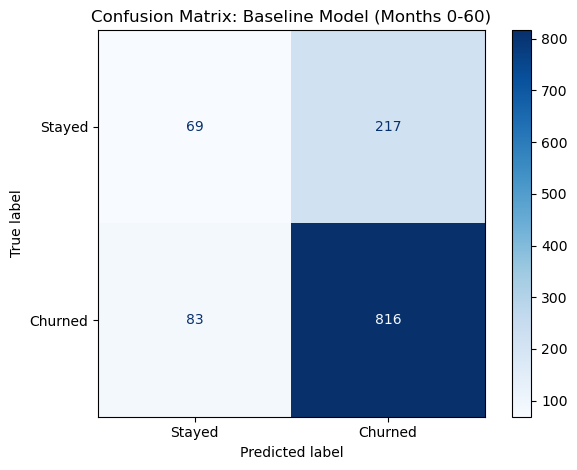

In [6]:
# Predict probabilities
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

# Get metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Stayed', 'Churned']
)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Baseline Model (Months 0-60)")
plt.tight_layout()
plt.show()

The model is overly pessimistic, predicting that players will churn more than they actually do

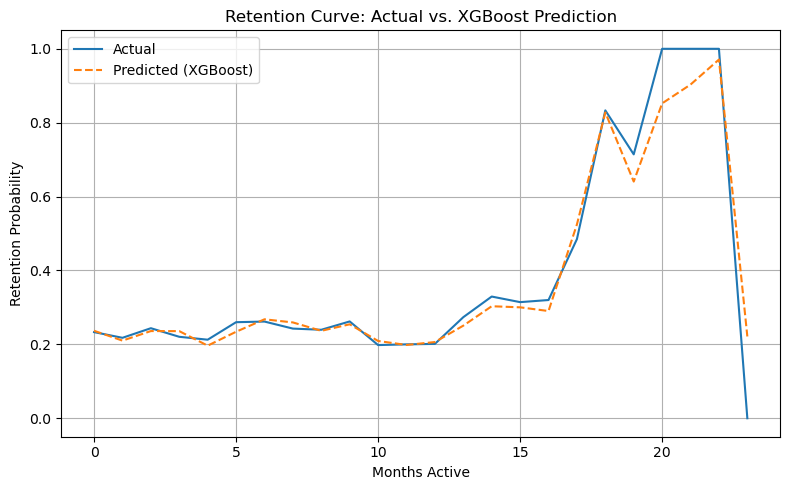

In [7]:
# Predict churn probability across all data
df['churn_proba'] = xgb_model.predict_proba(df[features])[:, 1]

# Compare actual vs predicted retention
retention_actual = 1 - df.groupby('months_active')['churned'].mean()
retention_pred = 1 - df.groupby('months_active')['churn_proba'].mean()

plt.figure(figsize=(8, 5))
sns.lineplot(x=retention_actual.index, y=retention_actual, label='Actual')
sns.lineplot(x=retention_pred.index, y=retention_pred, label='Predicted (XGBoost)', linestyle='--')
plt.title('Retention Curve: Actual vs. XGBoost Prediction')
plt.xlabel('Months Active')
plt.ylabel('Retention Probability')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


THe model tracks well player retention, showing more deviation from the actual values at the tail of the chart, where the data is more sparse.

Regarding the metrics, the model has a good accuracy for being a a simple model with default hyperparameters. AUC is low, but it's expected for a simple model. The next step would be choosing the metrics to focus on, and perform cross-validation and hyperparameter tuning to improve the model's performance. For this challenge, we'll leave it as is

### 4. SHAP Analysis (feature importance)
This is completely personal and I know is wasn't requested in the challenge, but I wanted to include it in order to help me understand the data better and see what features contribute the most to predict churn, as this is valuable insight

In [8]:
# Create the exaplainer using the trained model
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_test)

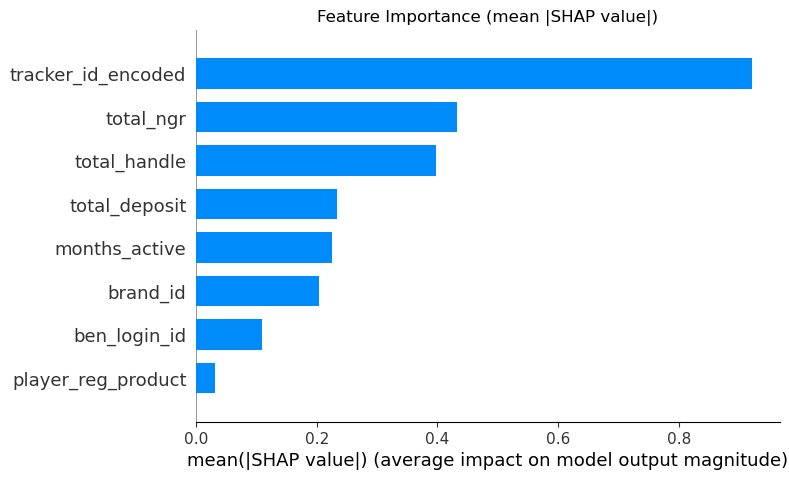

In [9]:
plt.figure(figsize=(8, 4))
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)
plt.tight_layout()
plt.title('Feature Importance (mean |SHAP value|)')
plt.show()

What this tells us is that the feature that contributes the most to explain churn is tracker_id, which is the place in our site where the player originated. This is very important, since deeper analysis would tell us which trackers are the ones that contribute the most to player churn.

total_ngr and total_handle are the next most importante features, which make sense.

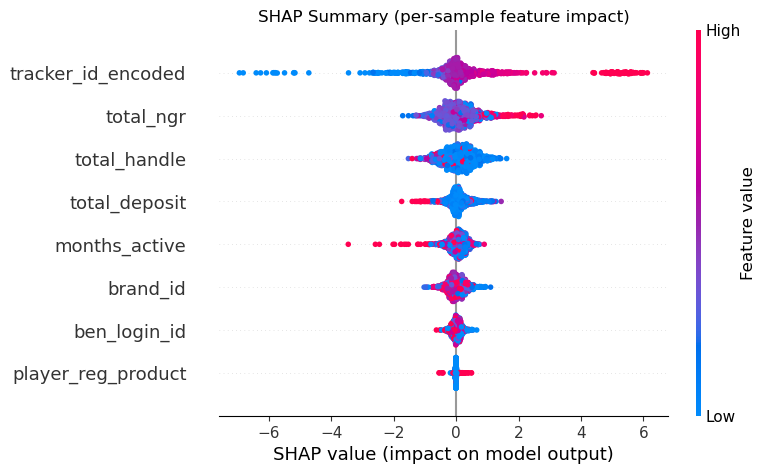

In [10]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.title('SHAP Summary (per‐sample feature impact)')
plt.show()

This plot just shows how much each feature affected each data point's prediction. And again, it shows how tracker_id had the most impact of all the features